# 知识工程-作业6 英文评论情感分类

2024214500 叶璨铭


## 代码与文档格式说明

> 本文档使用Jupyter Notebook编写，所以同时包括了实验文档和实验代码。

> 本次实验项目采用了类似于 Quarto + nbdev 的方法来同步Jupyter Notebook代码到python文件, 因而我们的实验文档导出为pdf和html格式可以进行阅读，而我们的代码也导出为python模块形式，可以作为代码库被其他项目使用。
我们这样做的好处是，避免单独管理一堆 .py 文件，防止代码冗余和同步混乱，py文件和pdf文件都是从.ipynb文件导出的，可以保证实验文档和代码的一致性。

> 本文档理论上支持多个格式，包括ipynb, html, docx, pdf, md 等，但是由于 quarto和nbdev 系统的一些bug，我们目前暂时只支持ipynb, docx, pdf文件，以后有空的时候解决bug可以构建一个[在线文档网站](https://thu-coursework-machine-learning-for-big-data-docs.vercel.app/)。您在阅读本文档时，可以选择您喜欢的格式来进行阅读，建议您使用 Visual Studio Code (或者其他支持jupyter notebook的IDE, 但是VSCode阅读体验最佳) 打开 `ipynb`格式的文档来进行阅读。


> 为了记录我们自己修改了哪些地方，使用git进行版本控制，这样可以清晰地看出我们基于助教的代码在哪些位置进行了修改，有些修改是实现了要求的作业功能，而有些代码是对助教的代码进行了重构和优化。我将我在知识工程课程的代码，在作业截止DDL之后，开源到 https://github.com/2catycm/THU-Coursework-Knowledge-Engineering.git ，方便各位同学一起学习讨论。


## 代码规范说明

为了让代码清晰规范，在作业开始前，使用 `ruff format`格式化助教的代码; 在我们实现函数过程中，函数的docstring应当遵循fastai规范而不是numpy规范，这样简洁清晰，不会Repeat yourself。

![alt text](image.png)


同时注意到VSCode-Pylance插件的报错

![alt text](image-1.png)

我们需要安装 AllenNLP，打开 https://github.com/allenai/allennlp，可以发现 “This repository was archived by the owner on Dec 17, 2022. It is now read-only.” 也就是说 AllenNLP 不再更新，是个比较老旧的库。

allennlp是"An Apache 2.0 NLP research library, built on PyTorch, for developing state-of-the-art deep learning models on a wide variety of linguistic tasks.", PyTorch写的NLP库，而Elmo则是其支持的一个算法。

我们服务器空间有限，为了避免单独为了allennlp重新安装老旧的PyTorch占满磁盘空间，决定手动修改 requirements.txt

```bash
git submodule add https://github.com/allenai/allennlp.git
cd allennlp
vim requirements.txt
conda activate yuequ
pip install -e .
```
发现 git 版本其实优于 pypi 版本，实际上没有改 requirements.txt 就可以增量安装。


## 原理回顾和课件复习



课上详细介绍了情感分析/观点挖掘任务的一些基本特点和难点，然后详细介绍了RNN的发展历程，最后提及了一下大模型方法FinGPT。

之前我们学的词向量不能解决一词多义，这次用Elmo可能会厉害一些。


## 数据准备

由于download.sh 的清华网盘链接过期，使用师兄群里发的文件

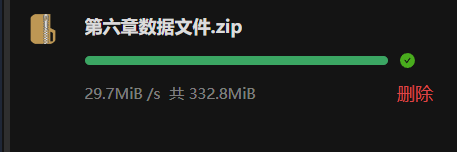

由于 /home 空间不足，使用软链接

```bash
cd 6.英文评论情感分类的作业
rm -rf data
ln -s /data/ycm/assignments/data
cd data
mv 第六章数据文件.zip data.zip
unzip data.zip
mv 第六章数据文件/* ./
rm -rf 第六章数据文件/
rm -rf data.zip

```

## 数据加载



我们看下 main.py 文件

使用到数据的地方是

```python
from data_util import MyDataset, collate_fn
...
MyDataset(
        "./data/train.tsv",
        max_length=max_length,
        train=True,
        max_example_num=max_train_example,
    ),
collate_fn=functools.partial(collate_fn, device=device),
```

助教已经帮我们实现了 collate_fn 关键是我们要写 MyDataset 

首先注意到 MyDataset[i] 返回的是一个元组，包含文本和标签

```python
def __getitem__(self, item):
    return self.text[item], self.label[item]
```

需要自己有list来存。现在可以写 load 

我们需要观察一下数据格式

![alt text](image-2.png)

train.tsv 和 dev.tsv 都是  “sentence label”，test.tsv 是 “index sentence”， 这次作业 main.py 只要求我们做 train 和 dev的,c传递的参数都是 train=True。

注意 csv 是 "comma separated values" 的缩写，tsv 是 "tab separated values" 的缩写，csv文件的分隔符是逗号，而tsv文件的分隔符是制表符（tab），所以我们需要使用 `sep="\t"` 来读取数据。


In [ ]:
from typing import List, Tuple
import torch
def load(
    self,
    file: str,  # file path
    train: bool = True,  # whether is training file
) -> Tuple[List[List[str]], List[int]]:  # Returns (text, label), text input and label
    """
    load file into texts and labels
    """
    import pandas as pd
    
    # 使用pandas读取文件，自动推断分隔符
    try:
        # 首先尝试tab分隔符，因为这是期望的格式
        df = pd.read_csv(file, sep='\t')
    except Exception as e:
        print(f"Error reading file with tab separator: {e}")
        print("Trying to read with auto-detected separator...")
        # 如果失败，让pandas尝试自动推断分隔符
        df = pd.read_csv(file, sep=None, engine='python')

    text = df['sentence'].astype(str).tolist()
    # 分词
    text = [sentence.split() for sentence in text]
    
    if train:
        # 训练集格式: sentence  label
        label = df['label'].astype(int).tolist()
    else:
        # 测试集可能没有标签，默认为 -1 表示不知道
        label = [-1] * len(text)
        
    return text, label

注意助教对  Returns (text, label), text input and label 的类型标注有误。

首先label应该是 List[int] 类型，参考官方文档 https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html ，可以是float，但是不应该是str类型。

其次text不应该是 List[str], 这里我们需要查看allennlp的 batch_to_ids 函数的约定 https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py ，可以看到其要求的输入是 List[List[str]], 也就是说需要对句子进行分词！


![](image-3.png)

我们差点就被原本的注释带偏啦，还好检查了allennlp的文档。


分词并不难，因为这次作业是 “英文评论情感分类”，可以直接按照空白符分词，使用 `str.split()` 就可以了，不需要上次那样用结巴分词。

当然，如果做得细致些，应该用 elmo 的 tokenier 去做分词，或者用nltk。 


现在可以实现 pad 函数

事实上，刚才我们看了源码知道，allennlp的elmo已经实现了padding，会根据句子和单词的最大长度来补齐，实际上我们不应该做任何操作！

当然，助教给了我们一个 max_length 的参数，实际上是用来限制句子长度的，超过这个长度的句子会被截断, 如果比elmo从数据发现的最大长度还要长，那多补一些也无妨，我们还是能实现一个。

不过最重要的问题是，pad token是什么？上一次作业是助教定义的词库，传入了pad和unknown的id，这次作业我们需要遵循allennlp的elmo的约定！

这下我们不得不继续查看源码 https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py

![](image-4.png)

这下可以确认pad token是0，从而实现

In [ ]:
def pad(self, 
        text_ids: torch.Tensor,  # size N*L*D
        )-> torch.Tensor: # Returns padded_text_id, size N*max_length*D
    """
    pad text_ids to max_length
    """
    N, L, D = text_ids.shape
    if L >= self.max_length:
        # 如果文本长度大于等于最大长度，截断
        return text_ids[:, :self.max_length, :]
    else:
        # 如果文本长度小于最大长度，填充
        padding = torch.zeros(N, self.max_length - L, D, dtype=text_ids.dtype, device=text_ids.device)
        padded_text_ids = torch.cat([text_ids, padding], dim=1)
        return padded_text_ids

测试一下, 用 https://github.com/google-deepmind/treescope 看清楚数据是什么样的

In [ ]:
import treescope
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [ ]:
dataset = MyDataset("./data/dev.tsv")
t, l = dataset[0]

## CNN 神经网络实现

这次的TextCNN和第四次作业的基本一样，只是embedding换成了allennlp的elmo representation，然后分类数量换成了2，其他的都一样。

上次我写得代码已经比较优雅高效，更多关于这段代码的理解和实现逻辑参阅 上次作业报告 https://github.com/2catycm/THU-Coursework-Knowledge-Engineering/blob/master/4.%E6%96%B0%E9%97%BB%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB%E7%9A%84%E4%BD%9C%E4%B8%9A/P_homework4.ipynb 

这次我们增加一个dropout

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self,
        options_file:str, # elmo file
        weight_file:str, # elmo weight file
        vector_size:int, # word embedding dim
        filter_size:List[int]=[2, 3, 4, 5], # kernel size for each layer of CNN
        channels:int=64, # output channel for CNN
        max_length:int =1024, # max length of input sentence
        dropout = 0.5, # dropout rate
    ):
        super(TextCNN, self).__init__()
        self.embedding = Elmo(options_file, weight_file, 1, dropout=0)
        ####################
        # 初始化嵌入层已经通过Elmo完成
        # 直接用上次作业的代码
        # Build a stack of 1D CNN layers for each filter size
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(in_channels=vector_size, 
                          out_channels=channels, 
                          kernel_size=k)
                # Conv1dViaConv2d(
                #     in_channels=vector_size,
                #     out_channels=channels,
                #     kernel_size=k,
                #     conv_2d=KAN_Convolutional_Layer,
                # )
                for k in filter_size
            ]
        )
        # Final linear layer for label prediction; number of classes equals len(label2index)
        # CNN的输出通道数 × 不同卷积核的数量
        self.linear = nn.Linear(channels * len(filter_size), 2) # 二分类问题（正面/负面）
        #  Dropout层，防止过拟合
        self.dropout = nn.Dropout(dropout)
        self.max_length = max_length
    def forward(self, 
        inputs:torch.Tensor, # input sentence, size N*L
        ) -> torch.Tensor: # predicted_logits: torch.tensor of size N*C (number of classes)
        # 获取ELMo嵌入表示
        inputs = self.embedding(inputs)["elmo_representations"][0]  # [N, L, vector_size]
        
        # Convolutional layer
        x = inputs.transpose(1, 2)  # 卷积需要将词向量维度放在最后 (N*D*L)
        x = [conv(x) for conv in self.convs]
        x = [nn.functional.gelu(i) for i in x]  # 每一个 i是 (N*C*Li) ， Li = L - ki + 1
        # Pooling layer
        x = [
            nn.functional.max_pool1d(
                i,
                kernel_size=i.size(2),  # 对 Li 去做 max_pooling
            ).squeeze(2)
            for i in x  # 每一个 i是 (N*C*Li)
        ]  # 每一个 item 变为 (N*C)
        # Concatenate all pooling results
        x = torch.cat(x, dim=1)  # 把每一个 item 拼接起来，变为 (N, C*len(filter_size))
        # 应用dropout
        x = self.dropout(x)
        # Linear layer
        x = self.linear(x)  # 分类，得到 (N*K)
        return x


其中我们还用了 Conv2d兼容层，来尝试实现 KAN Conv，但是并没有成功，这次老师讲解的重点是RNN，所以今天我们不过多探索Kolmogorov–Arnold Networks。

## RNN 神经网络实现

### LSTM 实现



### RWKV 实现

## 运行效果

首先我们直接运行一下CNN，为了让速度快一些，我改了batch size为16\*64，learning rate也\*16。

```bash
CUDA_VISIBLE_DEVICES=1 python main.py
```

![](image-5.png)

可以看到效果一般，只到80。

我们把batch size换回 64 再跑一次


在跑之前，我们修改一下 main.py 代码，第一，老规矩啦，要支持argparse；第二这一次助教用了tqdm，但是中间完全没有反馈，根本看不到网络训练地好不好，不知道刚才80的问题在哪，所以我们加上loss和acc的反馈

```python
out_bar = tqdm(range(total_epoch))
for epoch in out_bar: 
    ...
    bar = tqdm(train_loader)
    for text, label in bar:
        ...
        bar.set_description(f"Loss: {loss.item():.4f}")
    ...
    out_bar.set_description(f"Epoch: {epoch} Max Accuracy: {max_acc:.4f}")
```

好现在跑

![](image-6.png)

可以看到达到了 85，勉强复现了助教说的 86， 那么问题有可能是dropout=0.5 太大。

现在关闭dropout，看看效果

```bash
CUDA_VISIBLE_DEVICES=1 python main.py --model cnn --batch_size 64 --dropout 0
```